In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.utils.fixes import parse_version, sp_version

# This is line is to avoid incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
from sklearn.linear_model import QuantileRegressor


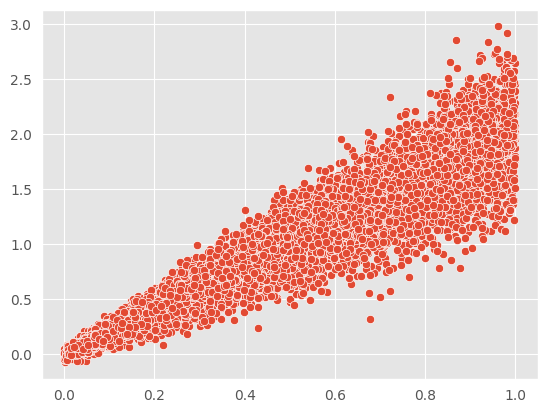

In [2]:
# Random dataset sampled from a gaussian distribution.
x = np.random.uniform(0,1, size = (10000,))
y = x * 2 + (x+0.1) * np.random.normal(0, 0.3, size = (10000,))

df = pd.DataFrame({'x': x,'y':y})

sns.scatterplot(df, x= x, y = y)

def two_hot(x, num_bins, vmin, vmax):
    """Converts a batch of scalars to soft two-hot encoded targets for discrete regression."""
    bin_size = (vmax - vmin) / (num_bins - 1)
    bin_idx = jnp.floor((x - vmin) / bin_size)
    bin_offset = (x - vmin) / bin_size - bin_idx
    soft_two_hot = jnp.zeros(num_bins, dtype=jnp.float32)
    soft_two_hot = soft_two_hot.at[bin_idx.astype(jnp.int32)].set(1 - bin_offset)
    soft_two_hot = soft_two_hot.at[bin_idx.astype(jnp.int32) + 1].set(bin_offset)
    soft_two_hot = soft_two_hot.reshape(1, num_bins)
    return soft_two_hot

In [3]:
nr_bins = 100
padding_prop = 0.3
v_max = jnp.max(y)
v_min = jnp.min(y)
padding = padding_prop * (v_max-v_min)
v_max += padding
v_min -= padding
bin_width = (v_max - v_min) / nr_bins
sigma_to_final_sigma_ratio = 1.
support = jnp.linspace(v_min, v_max, nr_bins + 1, dtype=jnp.float32)
centers = (support[:-1] + support[1:]) / 2
sigma = bin_width * sigma_to_final_sigma_ratio

def hl_gauss_encode(x):
    cdf_evals = jax.scipy.special.erf((support - x) / (jnp.sqrt(2) * sigma))
    z = cdf_evals[-1] - cdf_evals[0]
    target_probs = cdf_evals[1:] - cdf_evals[:-1]
    target_probs /= z
    return target_probs


def convert_prob_to_value(probs):
    return jnp.sum(probs * centers, axis=-1)


class LogisticRegressionModel(nn.Module):
  @nn.compact
  def __call__(self, x):
    assert x.shape[0] == 1
    n_sines = 3
    sines = [jnp.sin(x * i) for i in range(1, n_sines+1)]
    cosines = [jnp.cos(x * i) for i in range(1, n_sines+1)]
    x = jnp.concat([x, *sines, *cosines])
    f = nn.Dense(features=20)(x)
    f = nn.relu(f)
    f = nn.Dense(features=20)(f)
    f = nn.relu(f)
    f = nn.Dense(features=20)(f)
    f = nn.relu(f)
    f = nn.Dense(features=20)(f)
    f = nn.relu(f)
    return nn.Dense(features=nr_bins)(f)

model = LogisticRegressionModel()

params = model.init(jax.random.PRNGKey(45), jnp.array([1.]))

#jax.vmap(hl_gauss_encode)(y)

sum(x.size for x in jax.tree_util.tree_leaves(params)), [(x.size) for x in jax.tree_util.tree_leaves(params)]

(3520, [20, 140, 20, 400, 20, 400, 20, 400, 100, 2000])

In [4]:

def softmax_cross_quantropy(
    logits: jax.Array,
    labels: jax.Array,
    weights: jax.Array,
) -> jax.Array:
  return -jnp.sum(labels * jax.nn.log_softmax(logits, axis=-1) * weights, axis=-1)


def loss_fn(params, apply_fn, x, y, tau):
  """Binary cross entropy."""
  y_encoded = hl_gauss_encode(y)
  logits = apply_fn(params, x).squeeze()
  # weights = (centers < y) * tau + (centers >= y) * (1-tau)
  
  pred = convert_prob_to_value(jax.nn.softmax(logits))
  overest = pred > y
  coef = jnp.abs(tau-overest)
  assert logits.shape == y_encoded.shape, (logits.shape, y_encoded.shape)
  return coef * optax.softmax_cross_entropy(logits, y_encoded)

In [5]:
from typing import Callable, Sequence, Union


def batch_loss_fn(
    loss_fn: Callable,
    in_axes: Sequence[Union[int, None]] = (),
    out_axes: Sequence[Union[int, None]] = 0,
    has_aux: bool = False,
) -> Callable:
    _batched_loss_fn = jax.vmap(loss_fn, in_axes=in_axes, out_axes=out_axes)

    def _f(*args):
        if has_aux:
            value, aux = _batched_loss_fn(*args)
            return jnp.mean(value), jax.tree_map(lambda x: jnp.mean(x), aux)
        else:
            value = _batched_loss_fn(*args)
            return jnp.mean(value)

    return _f

batch_loss_fn = batch_loss_fn(loss_fn, in_axes=[None, None, 0, 0, None])
loss_value_and_grad = jax.value_and_grad(batch_loss_fn)

def update_weights(params, optimizer_state, x, y,  apply_fn, optimizer, tau):
    loss, grad = loss_value_and_grad(params, apply_fn, x[:, None], y[:, None], tau)
    weight_updates, new_states = optimizer.update(grad, optimizer_state)
    new_params = optax.apply_updates(params, weight_updates)
    return new_params, new_states , loss

In [6]:
# optimizer = optax.chain(
#     optax.clip_by_global_norm(10.0),
#     optax.adam(learning_rate = .3)
# )
optimizer = optax.sgd(learning_rate=.3)
optimizer_state = optimizer.init(params)

def train_epoch(params, optimizer_state, tau):
  # batch_indices = np.random.choice(len(df.x.values), 2048)
  # x = df.x.values[batch_indices]
  # y = df.y.values[batch_indices]
  x = df.x.values
  y = df.y.values
  new_params, new_states, l = update_weights(params,
                                          optimizer_state,
                                          x,
                                          y,
                                          model.apply,
                                          optimizer,
                                          tau)
  logits = jax.vmap(model.apply, in_axes=[None, 0])(new_params, df.x.values[:, None])
  y_values = convert_prob_to_value(jax.nn.softmax(logits, axis=-1))
  l2 = jnp.mean(optax.l2_loss(y_values, df.y.values))
  return new_params, new_states, l, l2

Text(0.5, 1.0, 'Before Training')

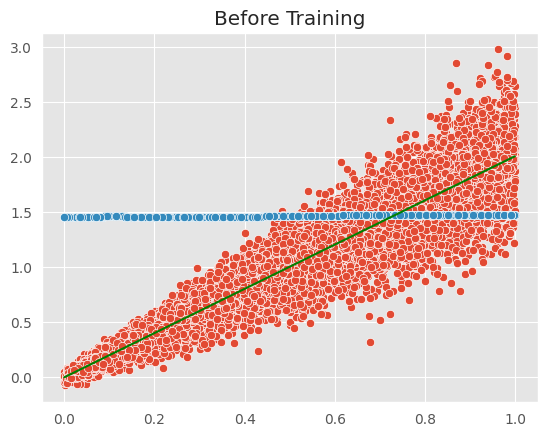

In [7]:
def plot_result(ax, params, epoch, l2, loss, tau):
  sampled_x = jax.random.uniform(jax.random.key(0), shape=(1000,1)) * (x.max() - x.min()) + x.min()
  pred_y = jax.vmap(model.apply, in_axes=[None, 0])(params, sampled_x)
  qr = QuantileRegressor(quantile=tau, alpha=0, solver=solver)
  y_pred = qr.fit(x[:, None], y).predict(sampled_x)
  sns.scatterplot(df, x= x, y = y, ax = ax)
  sns.scatterplot(
      x=sampled_x.squeeze(), 
      # y=pred_y[:, 0]
      y=convert_prob_to_value(jax.nn.softmax(pred_y.squeeze())),
      ax=ax)
  sns.lineplot(x=sampled_x.squeeze(), y=y_pred.squeeze(), color='green', ax=ax)
  ax.set_title(f'Epoch: {epoch} : l2: {l2:.2f}, loss:{loss:.2f}', fontsize = 10)
fig, ax = plt.subplots(1,1,)
plot_result(ax, params, 0,0,0, 0.5)
ax.set_title('Before Training')

  0%|          | 0/600 [00:00<?, ?it/s]

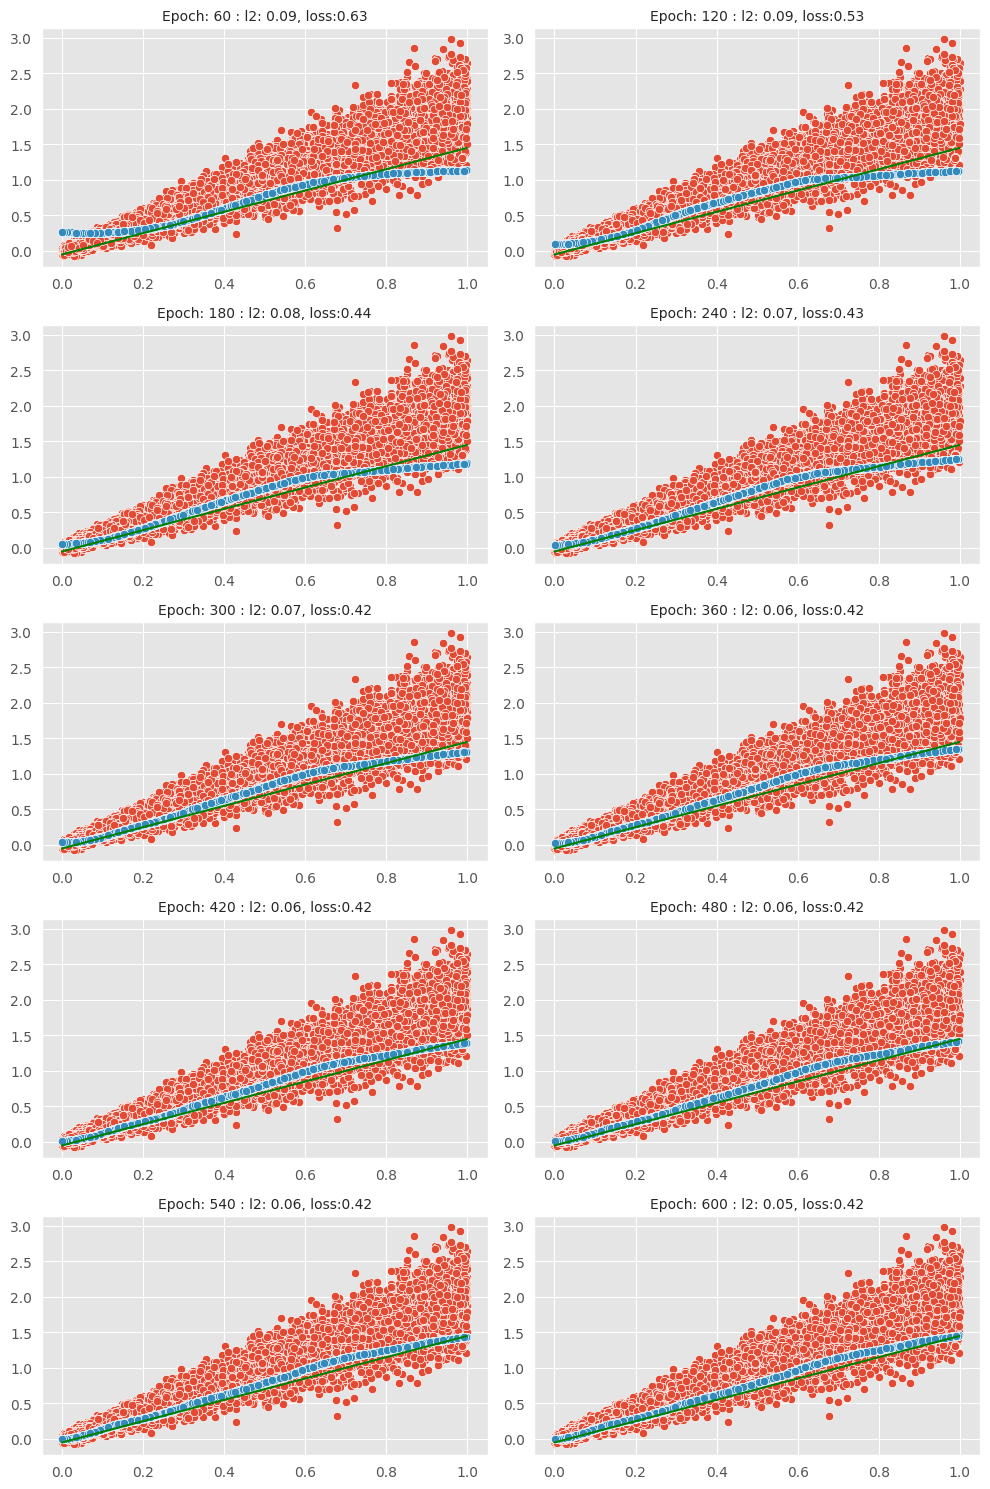

In [8]:
from tqdm.auto import trange
epochs = 600
log_every = epochs//10
fig, axes = plt.subplots(epochs//log_every//2, 2, figsize = (10,15))
axes = axes.flatten()
for epoch in trange(0, epochs):
  tau = 0.05
  params, optimizer_states, l, l2 = train_epoch(params, optimizer_state, tau=tau)
  if epoch % log_every == log_every-1:   
    plot_result(axes[epoch // log_every], params, epoch+1, l2, l, tau)
plt.tight_layout()